In [1]:
!pip install -U transformers

In [2]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("object-detection", model="microsoft/table-transformer-structure-recognition")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Device set to use cpu


In [3]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

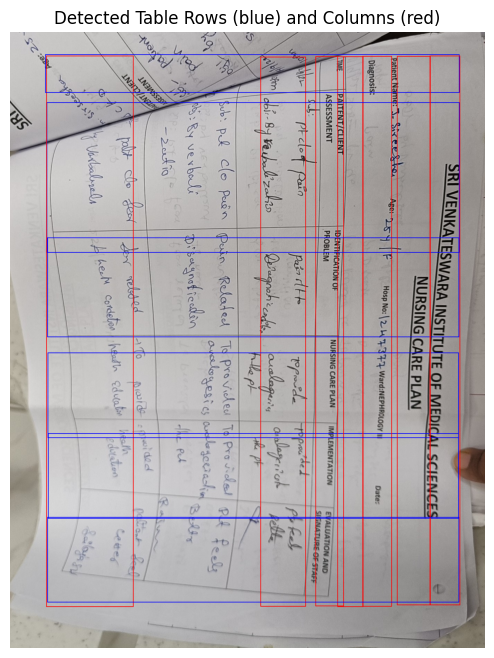

In [18]:
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
import cv2
import matplotlib.pyplot as plt

# Load image
image_path = "/content/IMG20240813150548.jpg"
image = Image.open(image_path).convert("RGB")

# Load processor and model
processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

# Run inference
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# Post-process output
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]
id2label = model.config.id2label

# Create drawing image
draw = ImageDraw.Draw(image)

# Filter only rows and columns and draw
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    label_text = id2label[label.item()]
    if label_text in ["table row", "table column"]:
        box = box.tolist()
        color = "blue" if label_text == "table row" else "red"
        draw.rectangle(box, outline=color, width=2)

# Display final image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Detected Table Rows (blue) and Columns (red)")
plt.show()


In [27]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image

# Load model
MODEL_PATH = "frozen_inference_graph.pb"  # your trained model
LABEL_MAP_PATH = "label_map.pbtxt"

def load_model(model_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(model_path, "rb") as fid:
            od_graph_def.ParseFromString(fid.read())
            tf.import_graph_def(od_graph_def, name="")
    return detection_graph

def detect_tables(image_path, detection_graph):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    with detection_graph.as_default():
        with tf.compat.v1.Session(graph=detection_graph) as sess:
            # Get tensors
            boxes = detection_graph.get_tensor_by_name("detection_boxes:0")
            scores = detection_graph.get_tensor_by_name("detection_scores:0")
            classes = detection_graph.get_tensor_by_name("detection_classes:0")
            num_detections = detection_graph.get_tensor_by_name("num_detections:0")
            image_tensor = detection_graph.get_tensor_by_name("image_tensor:0")

            # Run detection
            (boxes_out, scores_out, classes_out, num_out) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_expanded}
            )

            # Draw bounding boxes on the image
            h, w, _ = image.shape
            for i in range(int(num_out[0])):
                if scores_out[0][i] > 0.5:  # confidence threshold
                    box = boxes_out[0][i]
                    y1, x1, y2, x2 = (box * [h, w, h, w]).astype("int")
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return image

# Load and run
graph = load_model(MODEL_PATH)
output = detect_tables("sample_table.jpg", graph)

# Show result
cv2.imshow("Detected Table", output)
cv2.waitKey(0)
cv2.destroyAllWindows()


NotFoundError: frozen_inference_graph.pb; No such file or directory